In [1]:
from src.utils import *
from src.lsa import *

In [2]:
palette = {'canola': '#E8B6E6','coconut': '#9377C3', 'olive':'#8AC79C','palm': '#387D69','peanut': '#EE9F9B', 'soybean': '#B2BC3E', 'sunflower': '#495C65' }

# Latent semantic analysis

In [4]:
oils = ['coconut', 'olive', 'palm']

text = [pd.read_pickle(f'./data/{oil}/text.pkl.gz', compression='gzip') for oil in oils]
labels = [oil for oil in oils for _ in range(len(text[oils.index(oil)]))]

text = pd.concat(text)

In [5]:
if os.path.exists("./data/text/preprocessed_text.pkl.gz"):
    text_preprocessed = pd.read_pickle("./data/text/preprocessed_text.pkl.gz", compression='gzip')
else:
    text_preprocessed = text['text'].apply(tf_preprocess)
    text_preprocessed.to_pickle("./data/text/preprocessed_text.pkl.gz", compression='gzip')

In [6]:
# TF-IDF vectorization of the pre-processed Tweets
tfIdfVectorizer = TfidfVectorizer(use_idf=True,
                                  max_features=3000,
                                  min_df=10,
                                  max_df=0.7)
tfIdf = tfIdfVectorizer.fit_transform(text_preprocessed)

In [7]:
best_features = top_features(tfIdfVectorizer, 30) 

In [8]:
# SVD represent documents and terms in vectors
svd_model = TruncatedSVD(n_components=2,
                         algorithm='randomized',
                         n_iter=100,
                         random_state=122)
lsa = svd_model.fit_transform(tfIdf)

In [9]:
topic_encoded_df = pd.DataFrame(lsa, columns=["topic 1", "topic 2"])
topic_encoded_df["tweets"] = text_preprocessed.tolist()
topic_encoded_df["labels"] = labels

In [10]:
# Term - Topic matrix (U with only best_features)
encoding_matrix = pd.DataFrame(
    svd_model.components_,
    index=["topic 1", "topic 2"],
    columns=(tfIdfVectorizer.get_feature_names_out())).T
encoding_matrix_red = encoding_matrix.loc[best_features]

In [11]:
# take a random 10% sample (for the sake of visualization)
df = topic_encoded_df.sample(frac=0.1)

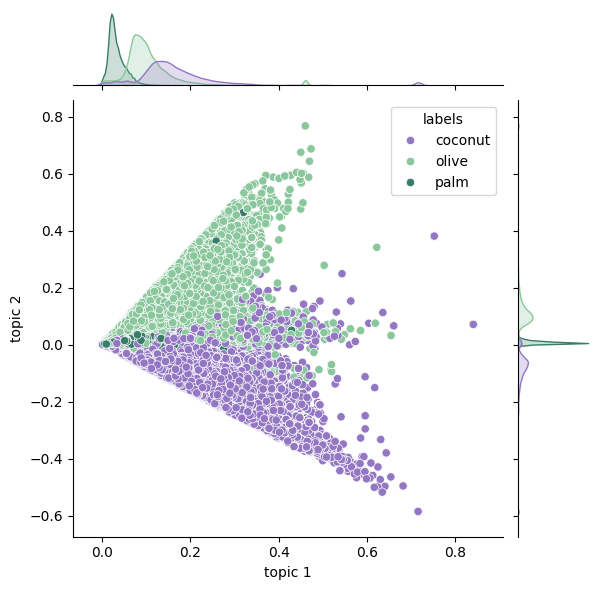

In [12]:
import seaborn as sns
import matplotlib as mpl

mpl.rcParams.update(mpl.rcParamsDefault)

ax = sns.jointplot(data=df, x="topic 1", y="topic 2", hue="labels", palette=palette)

plt.savefig("./plots/LSA.pdf", bbox_inches='tight')
plt.show()